# Inicialización del Entorno

## Parámetros Globales

In [64]:
from math import sqrt, pi, erf

MAX_UINT32 = 0xFFFFFFFF
MAX_UINT64 = 0xFFFFFFFFFFFFFFFF
sqrtPi = sqrt(pi)
erf1 = erf(1)
dimensiones = [2, 5, 10]
tamaños = [10**4, 10**5, 10**6]
valores_reales = {d: ((sqrtPi * erf1) / 2) ** d for d in dimensiones}

## Funciones Auxiliares

In [65]:
import ctypes
import tempfile
import subprocess
import os

c_code = r"""
#include <immintrin.h>

int rdseed32(unsigned int *out) {
    int ok;
    for (int i = 0; i < 10; ++i) {
        ok = _rdseed32_step(out);
        if (ok) return 1;
    }
    return 0;
}

int rdseed64(unsigned long long *out) {
    int ok;
    for (int i = 0; i < 10; ++i) {
        ok = _rdseed64_step(out);
        if (ok) return 1;
    }
    return 0;
}
"""

def compile_rdseed_lib():
    with tempfile.NamedTemporaryFile(suffix=".c", delete=False) as f:
        f.write(c_code.encode())
        c_path = f.name

    so_path = c_path.replace(".c", ".so")
    compile_cmd = [
        "gcc", "-shared", "-fPIC", "-O2", "-mrdseed", "-o", so_path, c_path
    ]

    subprocess.check_call(compile_cmd)
    os.remove(c_path)
    return ctypes.CDLL(so_path)

# Cargar lib y configurar argumentos
_rdseed = compile_rdseed_lib()
_rdseed.rdseed32.argtypes = [ctypes.POINTER(ctypes.c_uint)]
_rdseed.rdseed32.restype = ctypes.c_int

_rdseed.rdseed64.argtypes = [ctypes.POINTER(ctypes.c_ulonglong)]
_rdseed.rdseed64.restype = ctypes.c_int

# Funciones públicas
def seed32():
    """
    Intenta generar un entero aleatorio no negativo de 32 bits utilizando la instrucción RDSEED.
    """
    out = ctypes.c_uint()
    if _rdseed.rdseed32(ctypes.byref(out)) == 0:
        raise RuntimeError("RDSEED32 falló después de varios intentos.")
    return out.value

def seed64():
    """
    Intenta generar un entero aleatorio no negativo de 64 bits utilizando la instrucción RDSEED.
    """
    out = ctypes.c_ulonglong()
    if _rdseed.rdseed64(ctypes.byref(out)) == 0:
        raise RuntimeError("RDSEED64 falló después de varios intentos.")
    return out.value


In [66]:
def rotl32(x, k):
    """
    Función auxiliar que calcula la rotación de k bits del número x y devuelve como resultado
    un número de 32 bits.
    """
    return ((x << k) | (x >> (32 - k))) & MAX_UINT32 # Máscara para que sea un numero de 32bits

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import explícito por compatibilidad
import numpy as np
import ipywidgets as widgets

def sample_triplets(rng_func, M, n_triplets=5000):
    """Genera tripletas (x, y, z) normalizadas en [0, M)."""
    xs, ys, zs = [], [], []
    for _ in range(n_triplets):
        xs.append(int(rng_func() * M))
        ys.append(int(rng_func() * M))
        zs.append(int(rng_func() * M))
    return np.array(xs), np.array(ys), np.array(zs)


def plot_view(xs, ys, zs, elev=30, azim=45, title=""):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, s=5, c='b')
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def make_interactive_plot(xs, ys, zs, title, color):
    out = widgets.Output()
    with out:
        fig = plt.figure(figsize=(5, 4))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs, ys, zs, s=1, c=color)
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    return out

In [68]:
def adaptador_rng(rng, M):
    def wrapped():
        return int(rng() * M)
    return wrapped

## Parámetros de los Generadores

In [69]:
# Generador Congruencial Lineal
CGL_STATE = seed32()
a = 16807
M = 2**31 - 1

# Xorshift (32,64,128)
XOR32_STATE = seed32()
a_xorshift32 = 13
b_xorshift32 = 17
c_xorshift32 = 15
XOR64_STATE = seed64()
a_xorshift64 = 1
b_xorshift64 = 13
c_xorshift64 = 45
XOR128_STATE = [seed64(), seed64()]
a_xorshift128 = 23
b_xorshift128 = 18
c_xorshift128 = 15

# Xoshiro128
XOSHIRO_STATE = [seed32(), seed32(), seed32(), seed32()]
a_xoshiro128 = 9
b_xoshiro128 = 11
r_xoshiro128 = 17

### Chequeos

In [70]:
from sympy import factorint

factores_primos = factorint(M-1)
es_raiz_primitiva = True

for p in factores_primos:
    if pow(a, (M-1) // p, M) == 1:
        print(f"{a} NO es raíz primitiva de {M}")
        es_raiz_primitiva = False
        break

if es_raiz_primitiva:
    print(f"a = {a} es raíz primitiva de M = {M} y por lo tanto, el periódo K = M-1 del LCG es máximo")

a = 16807 es raíz primitiva de M = 2147483647 y por lo tanto, el periódo K = M-1 del LCG es máximo


In [71]:
print("================== Semillas de los generadores ==================")

# CGL
print(f"CGL_STATE       = {CGL_STATE}")

# Xorshift32
print(f"XOR32_STATE     = {XOR32_STATE}")

# Xorshift64
print(f"XOR64_STATE     = {XOR64_STATE}")

# Xorshift128
print(f"XOR128_STATE    = {XOR128_STATE[0]}, {XOR128_STATE[1]}")

# Xoshiro128
print(f"XOSHIRO_STATE   = {XOSHIRO_STATE[0]}, {XOSHIRO_STATE[1]}, {XOSHIRO_STATE[2]}, {XOSHIRO_STATE[3]}")


================== Semillas de los generadores ==================
CGL_STATE       = 1804855403
XOR32_STATE     = 3248225986
XOR64_STATE     = 10624853318423507103
XOR128_STATE    = 13804280187509005748, 16996574809653548461
XOSHIRO_STATE   = 1483998997, 211462072, 4112261657, 3640204821


## Clases

### Resultados

In [72]:
class ResultadoSimulacion:
    def __init__(self, generador, dimension, N, estimacion, tiempo, error_abs, varianza, ecm):
        self.generador = generador
        self.dimension = dimension
        self.N = N
        self.estimacion = estimacion
        self.tiempo = tiempo
        self.error_abs = error_abs
        self.varianza = varianza
        self.ecm = ecm

    def __repr__(self):
        return (f"{self.generador:12} | d={self.dimension:<2} | N={self.N:<7} | "
                f"Estimación={self.estimacion:.6f} | Error={self.error_abs:.2e} | "
                f"Varianza={self.varianza:.2e} | ECM={self.ecm:.2e} | "
                f"Tiempo={self.tiempo:.2f}s")


# IMPLEMENTACIONES

## Generador Congruencial Lineal (LCG)

In [73]:
def LCG():
    """
    Generador Múltiplicativo de números pseudoaleatorios normalizados en el intervalo [0,1) con parámetros:
    • a = 16807
    • M = 2^31 - 1 = 2147483647
    """
    global CGL_STATE
    CGL_STATE = (a*CGL_STATE) % M 
    return CGL_STATE / M

## Xorshifts (32,64,128)

In [74]:
def Xorshift32():
    """
    Generador de números pseudoaleatorios normalizados en el intervalo [0,1) con estado de 32 bits con parámetros:
    • a = 13
    • b = 17
    • c = 5
    """
    global XOR32_STATE
    XOR32_STATE ^= XOR32_STATE << a_xorshift32 
    XOR32_STATE ^= XOR32_STATE >> b_xorshift32
    XOR32_STATE ^= XOR32_STATE << c_xorshift32
    XOR32_STATE &= MAX_UINT32 # Máscara para que sea un numero de 32bits
    return XOR32_STATE / MAX_UINT32


In [75]:
def Xorshift64():
    """
    Generador de números pseudoaleatorios normalizados en el intervalo [0,1) con estado de 64 bits con parámetros:
    • a = 1
    • b = 13
    • c = 45
    """
    global XOR64_STATE
    XOR64_STATE ^= XOR64_STATE >> c_xorshift64
    XOR64_STATE ^= XOR64_STATE << b_xorshift64
    XOR64_STATE ^= XOR64_STATE >> a_xorshift64
    XOR64_STATE &= MAX_UINT64 # Máscara para que sea un numero de 64bits
    return XOR64_STATE / MAX_UINT64

In [76]:
def Xorshift128():
    """
    Generador de números pseudoaleatorios normalizados en el intervalo [0,1) con 2 estados de 64 bits con parámetros:
    • a = 23
    • b = 18
    • c = 5
    """
    global XOR128_STATE
    s1 = XOR128_STATE[0]
    s0 = XOR128_STATE[1]
    result = (s0 + s1) & MAX_UINT64 # Máscara para que sea un numero de 64bits
    XOR128_STATE[0] = s0
    s1 ^= s1 << a_xorshift128
    XOR128_STATE[1] = (s1 ^ s0 ^ (s1 >> b_xorshift128) ^ (s0 >> c_xorshift128)) & MAX_UINT64 # Máscara para que sea un numero de 64bits
    return result / MAX_UINT64

## Xoshiro128

In [77]:
def Xoshiro128():
    """
    Generador de números pseudoaleatorios normalizados en el intervalo [0,1) de 32 bits con 4 estados de 32 bits con 
    parámetros:
    • a = 9
    • b = 11
    • r = 7
    """
    global XOSHIRO_STATE
    result = (rotl32(XOSHIRO_STATE[0] + XOSHIRO_STATE[3], r_xoshiro128) + XOSHIRO_STATE[0]) & MAX_UINT32 # Máscara para que sea un numero de 32bits
    t = (XOSHIRO_STATE[1] << a_xoshiro128) & MAX_UINT32 # Máscara para que sea un numero de 32bits
    XOSHIRO_STATE[2] ^= XOSHIRO_STATE[0]
    XOSHIRO_STATE[3] ^= XOSHIRO_STATE[1]
    XOSHIRO_STATE[1] ^= XOSHIRO_STATE[2]
    XOSHIRO_STATE[0] ^= XOSHIRO_STATE[3] 
    XOSHIRO_STATE[2] ^= t
    XOSHIRO_STATE[3] =  rotl32(XOSHIRO_STATE[3], b_xoshiro128)
    return result / MAX_UINT32

# SIMULACIONES

In [78]:
from math import exp
from time import perf_counter as pc

generadores = {
    "LCG": {
        "func": LCG,
        "color": '#F68E5F'
    },
    "Xorshift32": {
        "func": Xorshift32,
        "color": '#F5DD90'
    },
    "Xorshift64": {
        "func": Xorshift64,
        "color": '#949083'
    },
    "Xorshift128": {
        "func": Xorshift128,
        "color": '#324376'
    },
    "Xoshiro128": {
        "func": Xoshiro128,
        "color": '#586BA4'
    }
}

def simular(rng, d ,N):
    """
    Dado un generador de números aleatorios (rng) que devuelve valores en [0,1), estima mediante el método de Monte Carlo
    la integral sobre el hipercubo [0,1]^d usando N muestras. 
    Devuelve:
    • estimación de la integral,
    • tiempo de ejecución,
    • varianza de las estimaciones,
    • error cuadrático medio (ECM).
    """
    muestras = np.empty(N, dtype=np.float64)

    inicio = pc()
    for i in range(N):
        prod = 1
        for _ in range(d):
            X = rng()
            prod *= exp(-1 * X**2)
        muestras[i] = prod
    final = pc()

    estimacion = np.mean(muestras)
    varianza = np.var(muestras)
    ecm = np.mean((muestras - valores_reales[d])**2)

    return estimacion, final-inicio, varianza, ecm

In [79]:
resultados = []

for nombre, datos in generadores.items():
    rng_func = datos["func"]  # Accede a la función generadora
    for d in dimensiones:
        valor_real = valores_reales[d]
        for N in tamaños:
            estimacion, tiempo, varianza, ecm = simular(rng_func, d, N)
            error_abs = abs(estimacion - valor_real)
            resultado = ResultadoSimulacion(nombre, d, N, estimacion, tiempo, error_abs, varianza, ecm)
            resultados.append(resultado)
            print(resultado)


LCG          | d=2  | N=10000   | Estimación=0.554639 | Error=3.11e-03 | Varianza=4.73e-02 | ECM=4.73e-02 | Tiempo=0.01s
LCG          | d=2  | N=100000  | Estimación=0.558226 | Error=4.80e-04 | Varianza=4.67e-02 | ECM=4.67e-02 | Tiempo=0.06s
LCG          | d=2  | N=1000000 | Estimación=0.557810 | Error=6.38e-05 | Varianza=4.67e-02 | ECM=4.67e-02 | Tiempo=0.59s
LCG          | d=5  | N=10000   | Estimación=0.234503 | Error=2.18e-03 | Varianza=2.31e-02 | ECM=2.31e-02 | Tiempo=0.01s
LCG          | d=5  | N=100000  | Estimación=0.233242 | Error=9.19e-04 | Varianza=2.27e-02 | ECM=2.27e-02 | Tiempo=0.12s
LCG          | d=5  | N=1000000 | Estimación=0.232297 | Error=2.55e-05 | Varianza=2.27e-02 | ECM=2.27e-02 | Tiempo=1.25s
LCG          | d=10 | N=10000   | Estimación=0.054004 | Error=3.03e-05 | Varianza=2.99e-03 | ECM=2.99e-03 | Tiempo=0.02s
LCG          | d=10 | N=100000  | Estimación=0.053789 | Error=1.85e-04 | Varianza=2.93e-03 | ECM=2.93e-03 | Tiempo=0.23s


KeyboardInterrupt: 

# Gráficas
`TODO`: Funcion real vs estimacion (d = 2,3)

## Distribución de lo Generadores

`TODO`: Modularizar

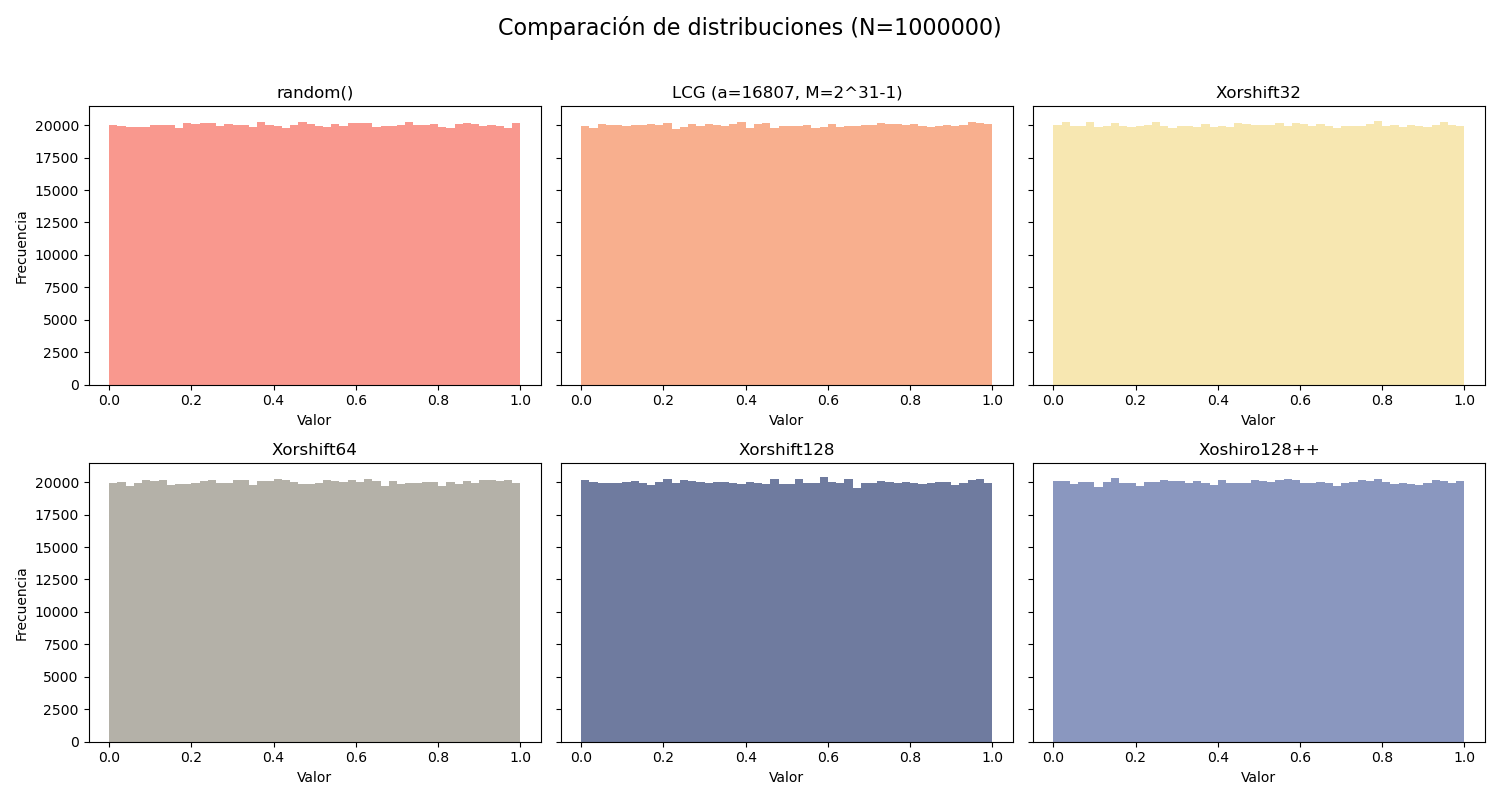

In [80]:
from random import random


# Generar muestras
N = 1_000_000
samples_random = [random() for _ in range(N)]
samples_lcg = [LCG() for _ in range(N)]
samples_xorshift32 = [Xorshift32() for _ in range(N)]
samples_xorshift64 = [Xorshift64() for _ in range(N)]
samples_xorshift128 = [Xorshift128() for _ in range(N)]
samples_xoshiro128 = [Xoshiro128() for _ in range(N)]

# Crear figura con 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

# Histograma random()
axes[0].hist(samples_random, bins=50, color= '#F76C5E', alpha=0.7)
axes[0].set_title('random()')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Histograma LCG
axes[1].hist(samples_lcg, bins=50, color='#F68E5F', alpha=0.7)
axes[1].set_title('LCG (a=16807, M=2^31-1)')
axes[1].set_xlabel('Valor')

# Histograma Xorshift32
axes[2].hist(samples_xorshift32, bins=50, color='#F5DD90', alpha=0.7)
axes[2].set_title('Xorshift32')
axes[2].set_xlabel('Valor')

# Histograma Xorshift64
axes[3].hist(samples_xorshift64, bins=50, color='#949083', alpha=0.7)
axes[3].set_title('Xorshift64')
axes[3].set_xlabel('Valor')
axes[3].set_ylabel('Frecuencia')

# Histograma Xorshift128
axes[4].hist(samples_xorshift128, bins=50, color='#324376', alpha=0.7)
axes[4].set_title('Xorshift128')
axes[4].set_xlabel('Valor')

# Histograma Xoshiro128++
axes[5].hist(samples_xoshiro128, bins=50, color='#586BA4', alpha=0.7)
axes[5].set_title('Xoshiro128++')
axes[5].set_xlabel('Valor')

# Ajustar diseño
plt.suptitle(f'Comparación de distribuciones (N={N})', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Generación de Puntos en el Cubo Unitario

In [81]:
from IPython.display import display

# Diccionario con widgets por generador
widgets_por_generador = {}

for nombre, data in generadores.items():
    gen_func = data["func"]
    color = data["color"]
    M = 2**31 if nombre == "LCG" else MAX_UINT32
    rng_func = adaptador_rng(gen_func, M)
    xs, ys, zs = sample_triplets(rng_func, M, 10_000)
    widget = make_interactive_plot(xs, ys, zs, f"Distribución 3D - {nombre}", color)
    widgets_por_generador[nombre] = widgets.VBox([
        widgets.Label(f"Generador: {nombre}"),
        widget
    ])

selector = widgets.Dropdown(
    options=list(generadores.keys()),
    description='Generador:',
)

contenedor = widgets.Output()

def mostrar_generador(change):
    contenedor.clear_output()
    with contenedor:
        display(widgets_por_generador[change['new']])

selector.observe(mostrar_generador, names='value')

display(selector, contenedor)

# Mostrar el primero por defecto
selector.value = list(generadores.keys())[0]


Dropdown(description='Generador:', options=('LCG', 'Xorshift32', 'Xorshift64', 'Xorshift128', 'Xoshiro128'), v…

Output()